Dans cette partie , il est question de faire le preprocessing de l'image en question les operations de segmentation , de traitement seront appliquees a l'image pour sortir l'image qui sera analyser a l'aide du OCR pour l'extraction des informations 

# type d'image

pour notre cas on choisit les cartes nationales d'identité pour ce format d'image 
le pipeline certificate est le plus adapté (voir fig 4)

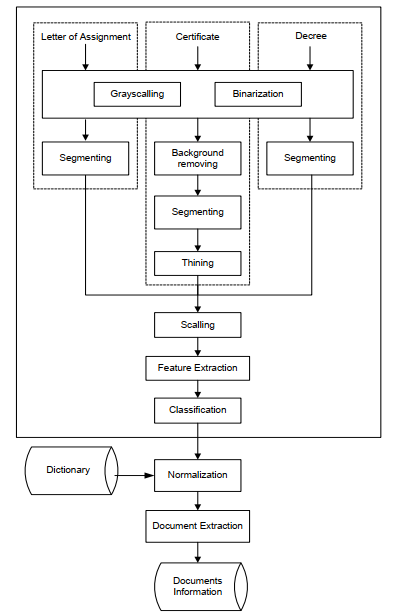

In [1]:
from PIL import Image # Import de la classe Image
pipeline = Image.open('pipeline.png') # ouverture du fichier
pipeline

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
#for resizing purpose
heightImg = 640
widthImg = 480

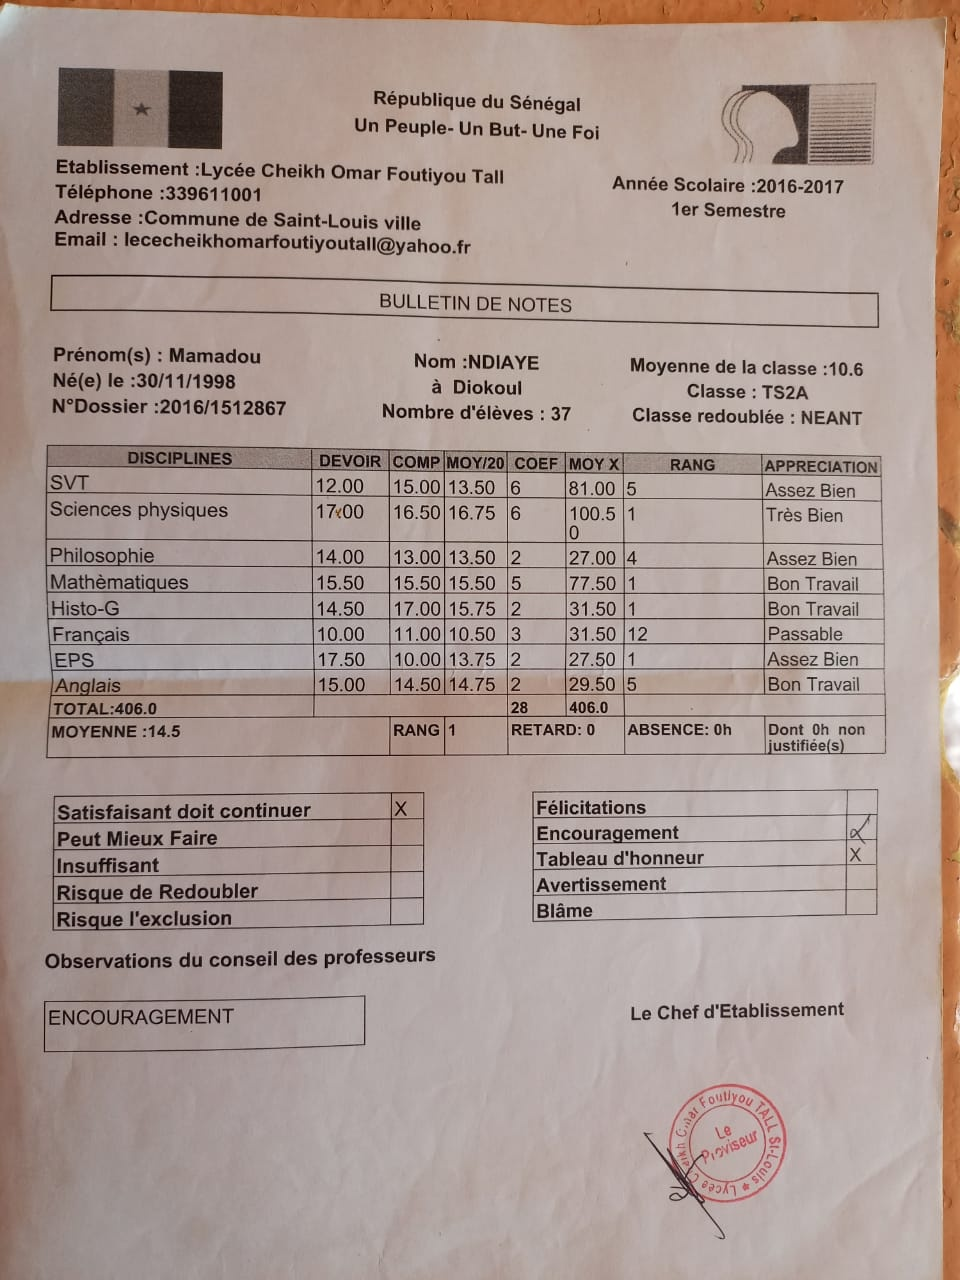

In [4]:
img = cv2.imread("bulletin1.jpeg")
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
try:
    cv2.imwrite("1.jpg", img)
except IOError :
    print ("erreur d'enregistrement de l'image")
im1 = Image.open('1.jpg')
im1


In [ ]:
#for resizing the image with given paramet
def resize(img, heightImg, widthImg):
    cv2.resize(img, (widthImg, heightImg))
    return img   

In [ ]:
img = resize(img ,heightImg , widthImg )

## grayscalling de l'image

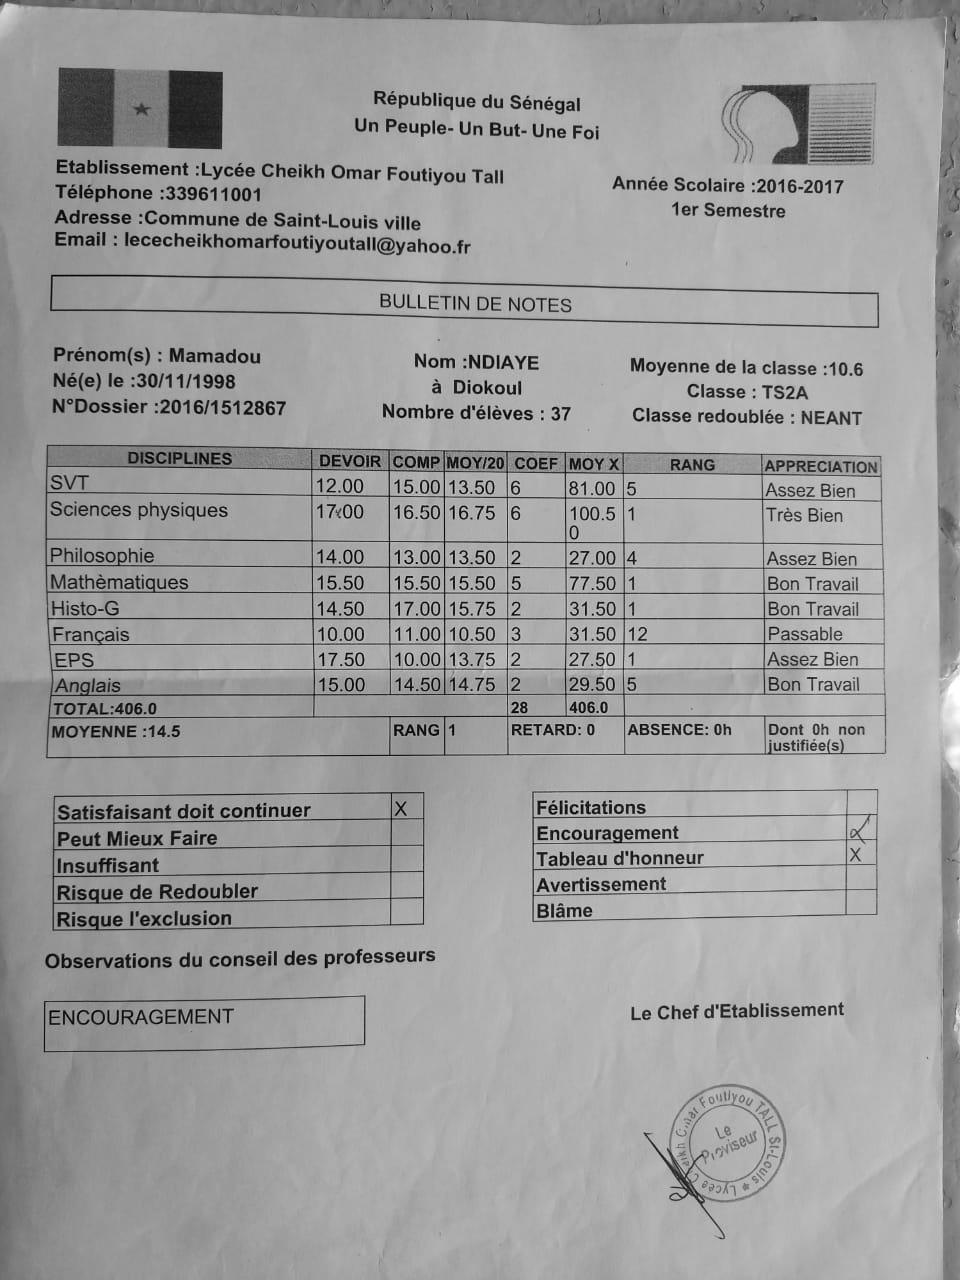

In [5]:
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
try:
    cv2.imwrite("2.jpg", imgGray)
except IOError :
    print ("erreur d'enregistrement de l'image")
im2 = Image.open('2.jpg')
im2

## binarisation

binarisation en utilisant le simple threesholding

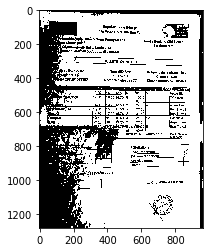

In [9]:
imgThres = cv2.threshold(imgGray,155,255,cv2.THRESH_BINARY)
plt.imshow(imgThres[1] , cmap = "Greys_r")

binarisation en utilisant la methode otsu

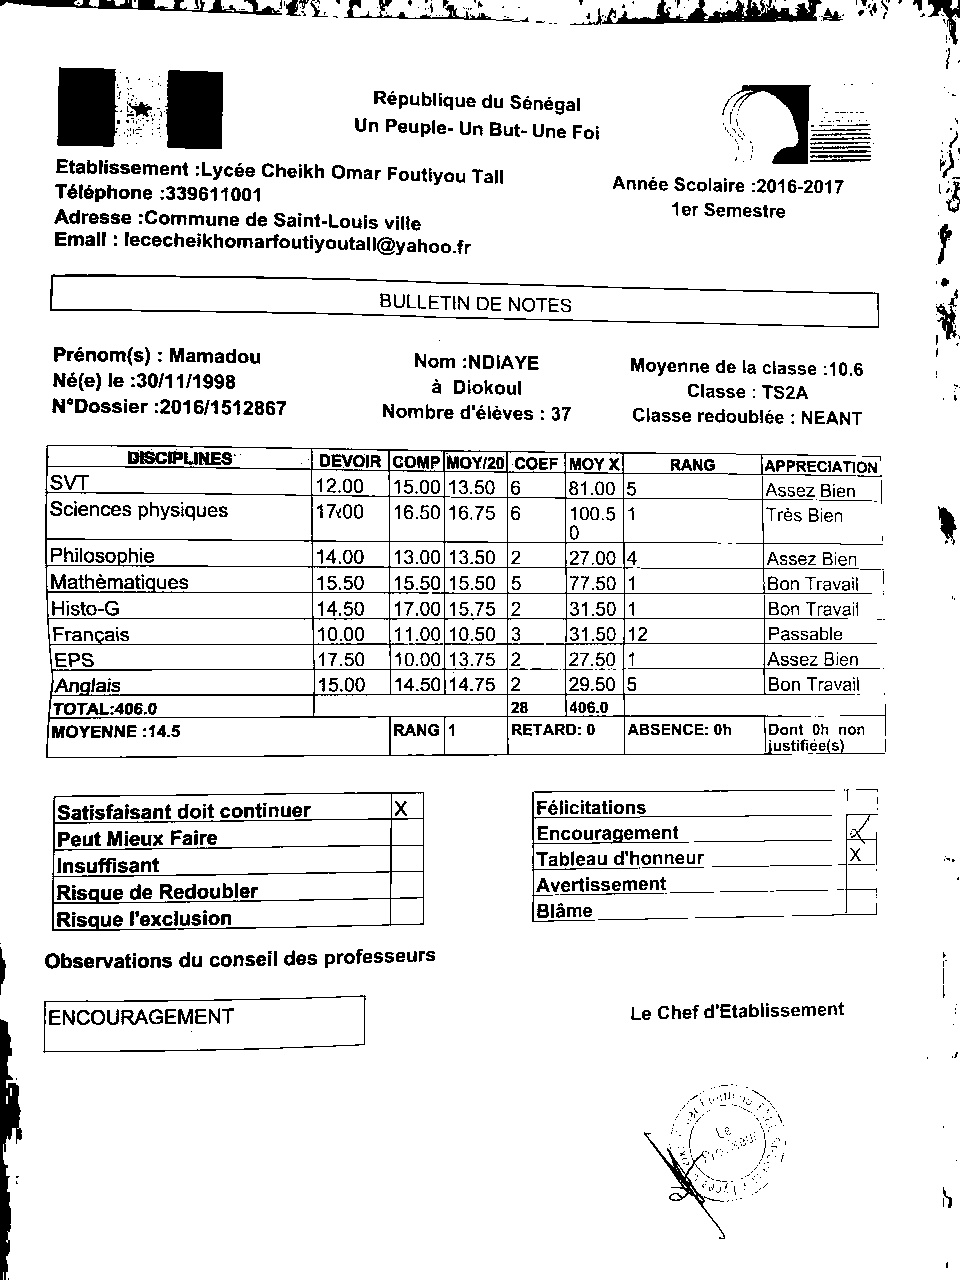

In [7]:
imgOtsu = cv2.threshold(imgGray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

try:
    cv2.imwrite("3.jpg", imgOtsu[1])
except IOError :
    print ("erreur d'enregistrement de l'image")
im2 = Image.open('3.jpg')
im2


## background removing 

## segmenting edge detection

gaussaian blur 

to reduce noise and detail

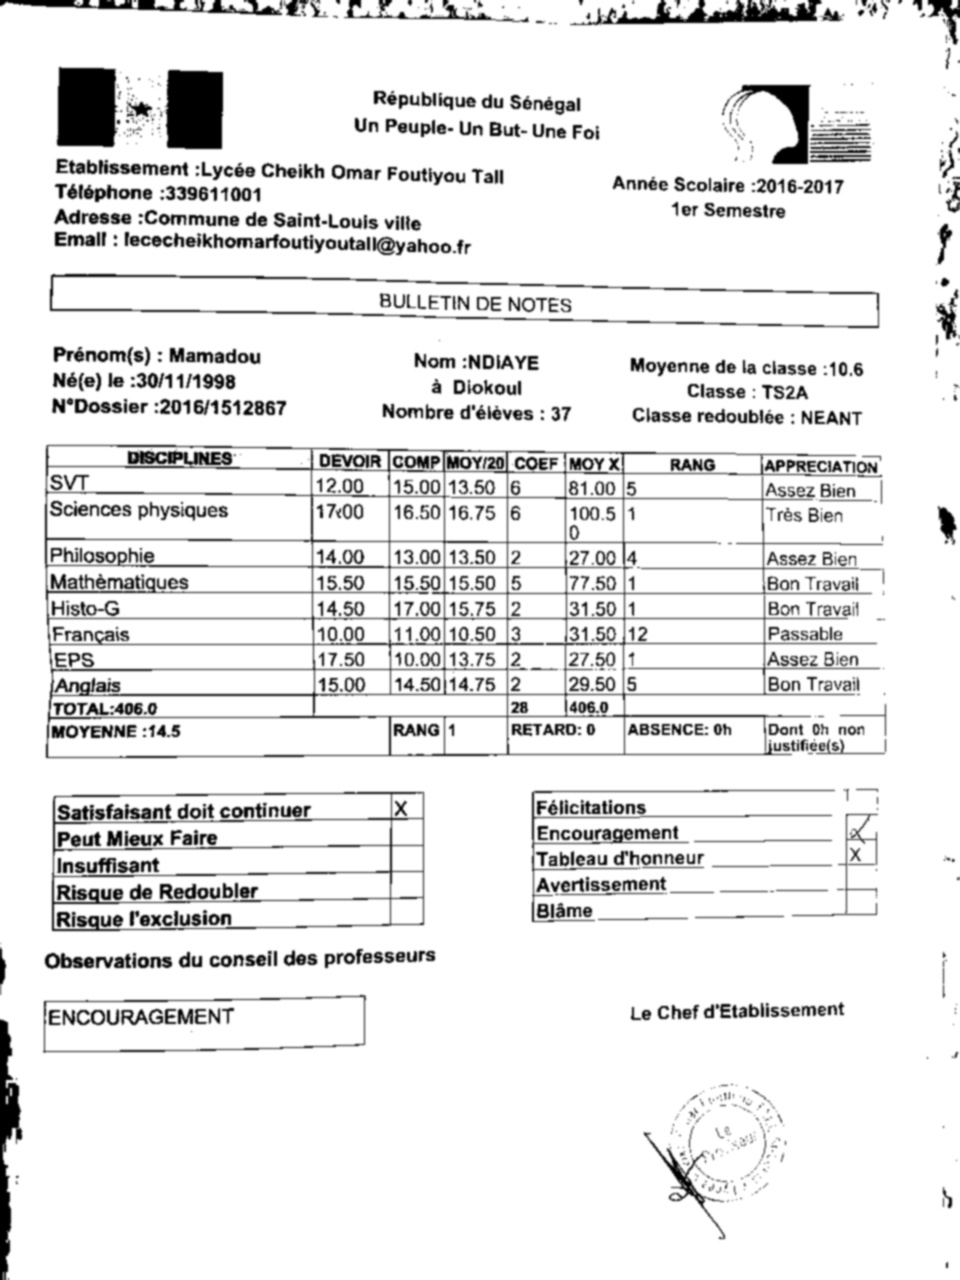

In [8]:
imgBlur = cv2.GaussianBlur(imgOtsu[1], (5, 5), 1)

try:
    cv2.imwrite("4.jpg", imgBlur)
except IOError :
    print ("erreur d'enregistrement de l'image")
im2 = Image.open('4.jpg')
im2

using Canny edge detector now


In [10]:
imgThreshold = cv2.Canny(imgGray, 200, 200)

apply now mathematic morphology 

In [11]:
kernel = np.ones((5, 5))
imgDial = cv2.dilate(imgThreshold, kernel, iterations=2)  # APPLY DILATION
imgThreshold = cv2.erode(imgDial, kernel, iterations=1)

find all contours now 

In [12]:
contours, hierarchy = cv2.findContours(
imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

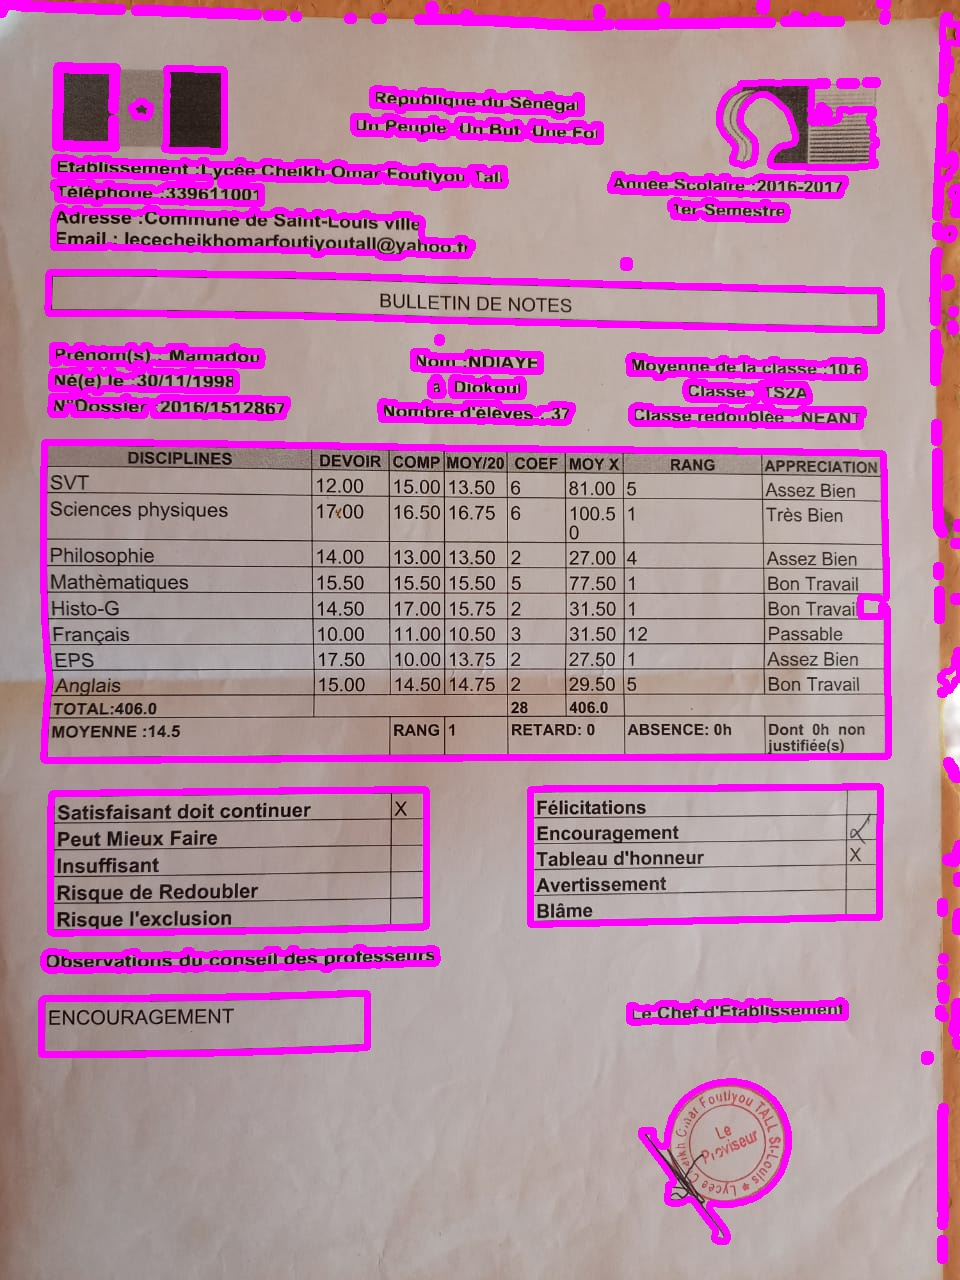

In [13]:
imgContours = img.copy() 
imgBiggestContour = img.copy()
# FIND ALL CONTOURS
allcontours = cv2.drawContours(imgContours, contours, -1, (255, 0, 255), 5)
try:
    cv2.imwrite("5.jpg", allcontours)
except IOError :
    print ("erreur d'enregistrement de l'image")
im2 = Image.open('5.jpg')
im2

In [14]:
for i in contours:
        area = cv2.contourArea(i)
        print(area)

88.0
498.0
13235.5
41.5
26.5
47.0
168.0
3314.0
18132.0
78.5
32.0
16.0
5926.0
74.0
48.0
24.0
105.5
52363.5
46390.0
115.5
348.0
30.0
124.0
44.0
24.0
18.0
353.0
261042.0
80.0
3538.0
2887.5
1842.5
1110.0
196.5
3459.5
2047.0
10257.5
20.0
232.5
36.0
16.0
60.0
33687.5
42.0
302.0
153.5
14271.0
1655.0
151.0
3594.0
10080.5
3545.0
668.0
225.0
3246.5
68.0
7836.0
48.0
4726.5
1066.0
627.0
36.0
24.0
628.0
288.5
20.0
33.0
68.0
508.0
45.0
49.0
903.5
44.5
71.5
589.0


found biggest contours to get the id card area

In [15]:
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area:
                biggest = approx
                max_area = area
    return biggest,max_area

def reorder(myPoints):

    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)

    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

In [16]:
biggest , max_area = biggestContour(contours)
biggest = reorder(biggest)
max_area

261042.0

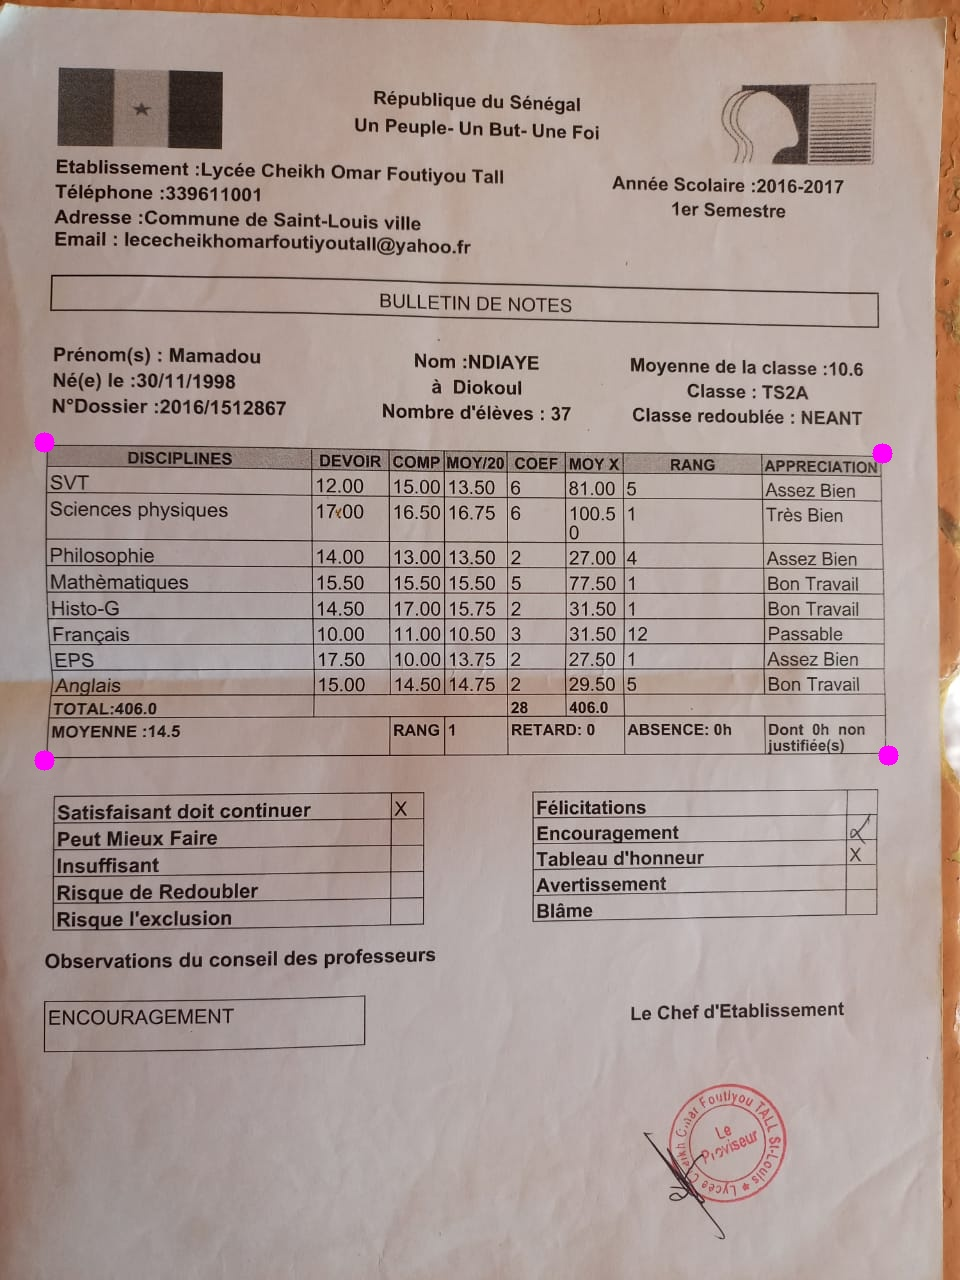

In [17]:
bigContours = cv2.drawContours(imgBiggestContour, biggest, -1, (255, 0, 255), 20)
try:
    cv2.imwrite("6.jpg", bigContours)
except IOError :
    print ("erreur d'enregistrement de l'image")
im2 = Image.open('6.jpg')
im2

lets now extract the area of the id only

In [18]:
#draw the rectangle 
def drawRectangle(img,biggest,thickness):
    cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)

    return img

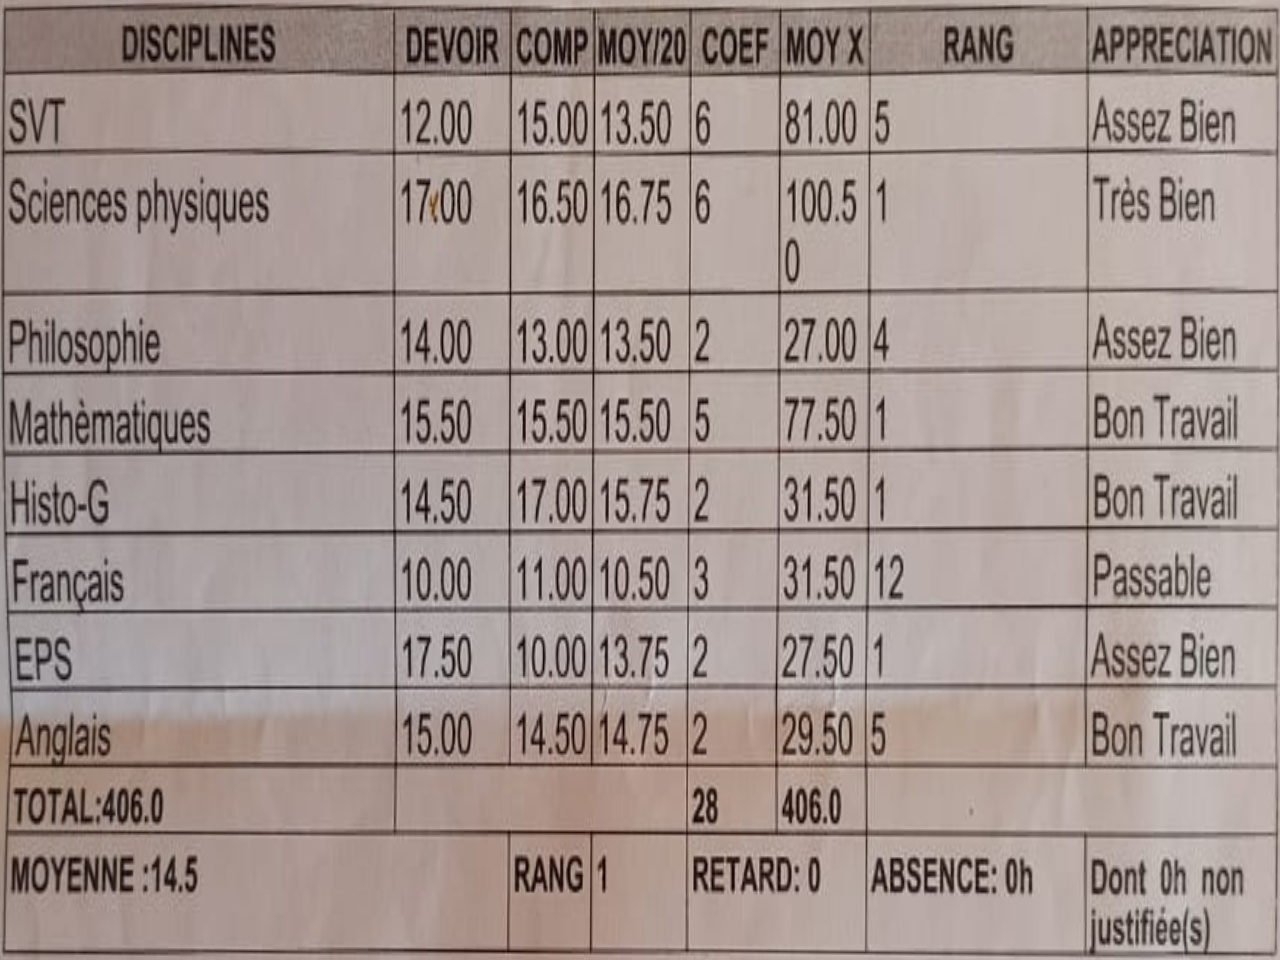

In [20]:

# DRAW THE BIGGEST CONTOUR
imgBigContour = drawRectangle(bigContours, biggest, 2)
pts1 = np.float32(biggest)  # PREPARE POINTS FOR WARP
pts2 = np.float32([[0, 0], [img.shape[0], 0], [0, img.shape[1]], [img.shape[0], img.shape[1]]])  # PREPARE POINTS FOR WARP
matrix = cv2.getPerspectiveTransform(pts1, pts2)
imgWarpColored = cv2.warpPerspective(img, matrix, (img.shape[0], img.shape[1]))
try:
    cv2.imwrite("7.jpg", imgWarpColored)
except IOError :
    print ("erreur d'enregistrement de l'image")
im2 = Image.open('7.jpg')
im2


In [29]:
# REMOVE 20 PIXELS FORM EACH SIDE
imgWarpColored = imgWarpColored[20 : imgWarpColored.shape[0] - 20, 20 : imgWarpColored.shape[1] - 20]
imgWarpColored = cv2.resize(imgWarpColored,  (img.shape[0], img.shape[1]))


on peut maintenant reappliquer les filtres

In [21]:
imgWarpGray = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)
thre , imgAdaptiveThre = cv2.threshold(imgWarpGray,0,255,cv2.THRESH_OTSU)

In [22]:
imgAdaptiveThre.shape

(960, 1280)

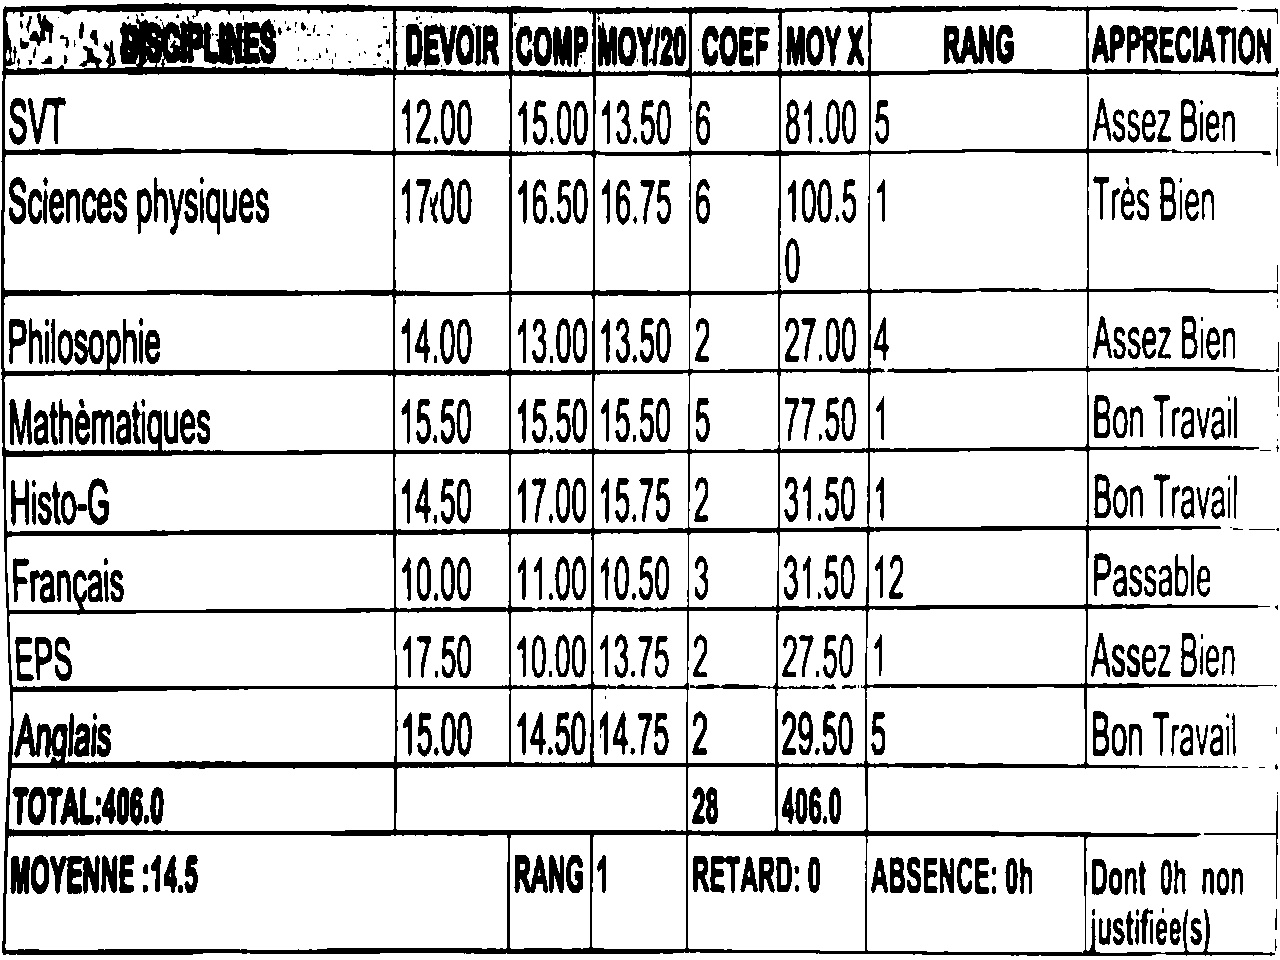

In [122]:
IDcard

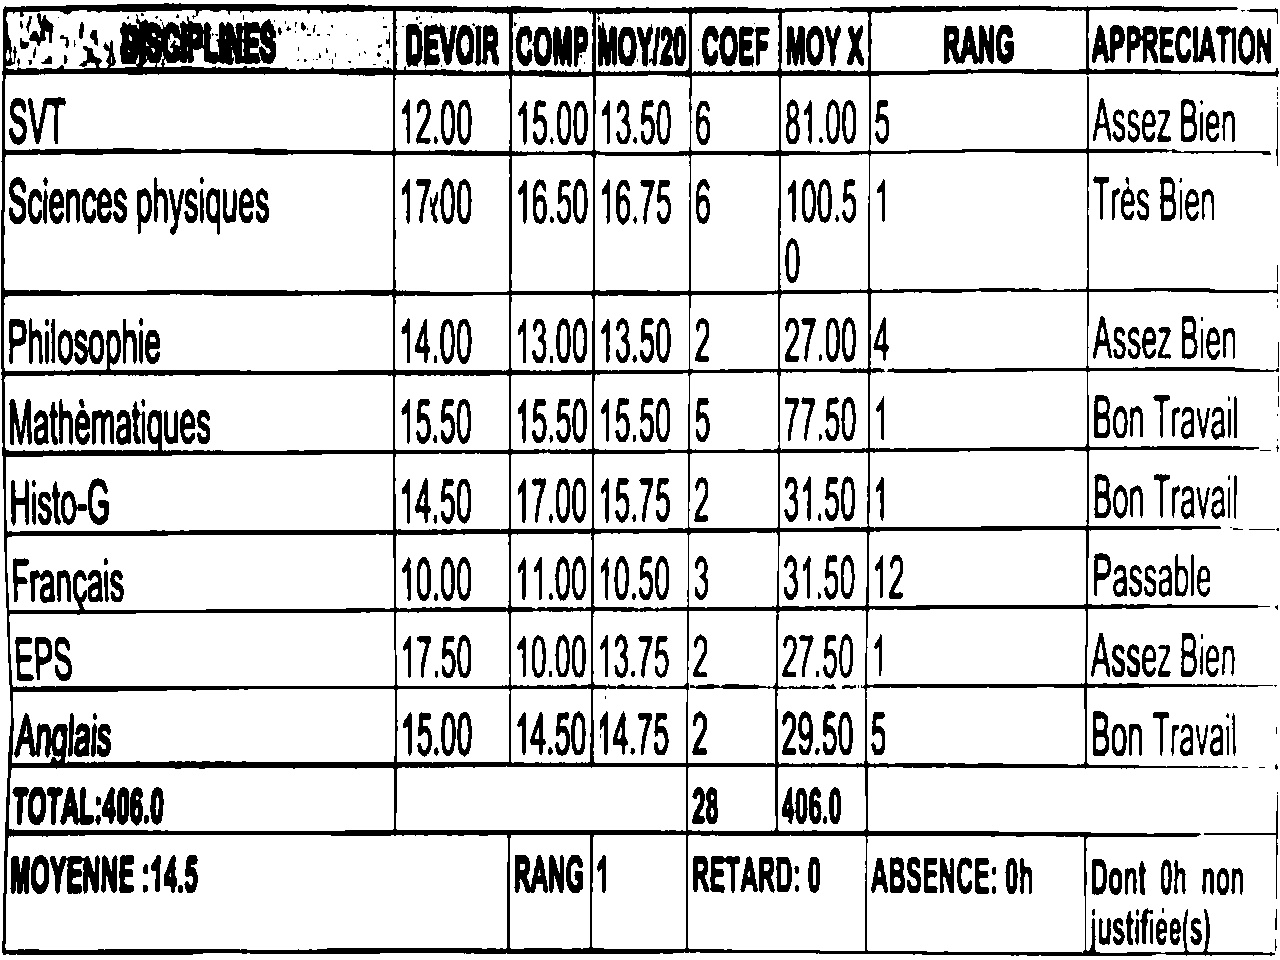

In [23]:
try:
    cv2.imwrite("8.jpg", imgAdaptiveThre)
except IOError :
    print ("erreur d'enregistrement de l'image")
IDcard = Image.open('8.jpg') # ouverture du fichier
IDcard

In [24]:
IDcard = Image.open('8.jpg') # ouverture du fichier
newIDcard=IDcard.crop((0 ,820 ,960 ,1200))
newIDcard
try:
    cv2.imwrite("9.jpg", newIDcard)
except IOError :
    print ("erreur d'enregistrement de l'image")
IDcard = Image.open('9.jpg') # ouverture du fichier
IDcard


error: OpenCV(4.5.4-dev) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


## la partie OCR now avec la librairie python tesseract

In [67]:
import pytesseract

In [303]:
cv2.rotate?

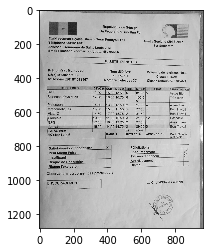

In [312]:
#lets read an image
image=cv2.imread('bulletin1.jpeg')
b , g , r =  cv2.split(image)
image = cv2.merge([r,g,b])
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
imgWarpGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(imgWarpGray , cmap="Greys_r")

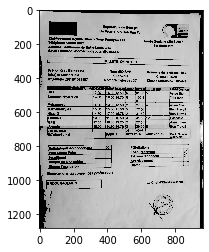

In [313]:
imgBlur = cv2.GaussianBlur(imgWarpGray ,(3,3) , 0)
ret , imgAdaptiveThre = cv2.threshold(imgBlur , 127 , 255 , cv2.THRESH_TOZERO)
plt.imshow(imgAdaptiveThre , cmap = "Greys_r")

In [360]:
try:
    cv2.imwrite("kanam2a.jpg", imgBlur)
except IOError :
    print ("erreur d'enregistrement de l'image")

In [74]:
try:
    cv2.imwrite("kontourw.jpg", allcontours)
except IOError :
    print ("erreur d'enregistrement de l'image")

In [371]:
image=cv2.imread('kanam2a.jpg')

In [68]:
pytesseract.pytesseract.tesseract_cmd = 'C://Program Files//Tesseract-OCR//tesseract.exe'

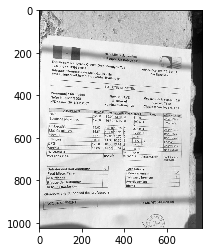

In [418]:
#lets read an image
image=cv2.imread('bulletin3.jpeg')
b , g , r =  cv2.split(image)
image = cv2.merge([r,g,b])
#image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
imgWarpGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(imgWarpGray , cmap="Greys_r")

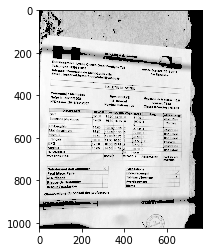

In [419]:
imgBlur = cv2.GaussianBlur(imgWarpGray ,(3,3) , 0)
ret , imgAdaptiveThre = cv2.threshold(imgBlur , 127 , 255 , cv2.THRESH_TOZERO)
plt.imshow(imgAdaptiveThre , cmap = "Greys_r")

In [424]:
#convert it into text
extractDetails=(pytesseract.image_to_string(imgBlur)).lower()
extractMoyenne=(pytesseract.image_to_string(image)).lower()

In [107]:
last = cv2.imread("ID.jpg")
lastDetails=(pytesseract.image_to_string(last)).lower()

In [108]:
lastDetails

'jh pipaiuaes”" tdevoiricompimoyi2n/ coef moy x] rang [appreciation\nsvt 12.00 115.00\n\nsciences physiques\n\nphilosophie\nmathematiques\nhisto-g\nfrancais\n\neps\n\nanglais\ntotal:406.0\n\n1700\n\n14.00\n15.90\n14.50\n10.00\n17.50\n\n15.00\n\n16.40\n\n13.00\n15.80\n17.00\n11.00\n10.00\n14.50\n\n13.50\n16.75\n\n1350\n15.50\n15.75\n10.50\n1375\n1475\n\nmoyenne $14.5 rang\n\n6 (b1.00\n6 100.4\n0\n\n2 (27.00\n\n2\n3 (3t.a0\nd\n2\n\nretard: 0\n\nabsence: oh\n\nassez bien |\ntrés bien\n\nassez bien |\nbon travail ;\nbon traval\npassable\n\nassez bien\nbon travail\n\ndont ch a\n\niustifiee(s) |\n'

In [417]:
extractMoyenne

"etablissement :lycée cheikh omar foutiyou tall\ntéléphone :339611001\n\nadresse :commune de saint-louis ville\n\nemail : lececheikhomarfoutiyoutall@yahoo fr\n\nrépublique du sénégal\nun peuple- un but- une foi\n\nannée scolaire :2016-2017\nter semestre\n\nbulletin de notes\n\nnom :ndiaye\n\nné(e) le :30/11/1998,\nn°dossier :2016/1512867\n\nnombre d’éléves ; 37\n\n‘satisfaisant doit cor\n\n[gomp|moviad] coef woy x]. rang [appreciation]\nsvt 15.00|13.50 |6 _|[81.00|5 lassez bien _\nsciences physiques 6 ee 51 |trés bien\n[philosophie [2 |27.00|4 ____|assez bien\nmathématiques 5 |77.50|4 bon travail\nhisto-g 231.504 bon travall\nfrancais i3 131.50 |12 ___|passable\nleps 2 [27.601 [assez bien\n{anglais 2 129.50 [5 [bon travail\nftotal:4060 ee eee\nmoyenne :14.5 retard: 0 |absence:0» [don on\n\nfélicitations\n\n|[peut mieux faire\n\nincouragement\n\nlinsuffisant\n\n‘tableau d'honneur\n\nrisque de redoubler\n\n‘avertissement\n\nrisque i'exclusion\n\n‘blame\n\n‘observations du conseil des pro

In [336]:
moyenne = moyenneSplit[1].split(" ")

In [337]:
moyenne[0]

'14.5'

In [427]:
pip install pdf2image

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pdf2image import convert_from_path

pdfs = r"bulletin.pdf"
pages = convert_from_path(pdfs, 350)

i = 1
for page in pages:
    image_name = "Page_" + str(i) + ".jpg"  
    page.save(image_name, "JPEG")
    i = i+1      